# NLP With Disaster Tweets

## Problem Description

The NLP With Disaster Tweets Kaggle competition aims to use NLP specific tools to predict disaster tweets. When using Twitter (or any other social media for that matter), people like to dramaticize what they are saying. The goal of this binary classification project is to distinguish tweets that are about real disasters versus tweets that are not.

For example, take the tweet: "On the plus side, LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE". It is clear to you and I that the author of this tweet was speaking metaphorically, however, the distinction for a computer is much harder. The goal is to build a model that can accurately classify disaster related tweets. 

The accuracy metric for this competition is the F1 score. 

## Data Description

The data supplied contains two files, a train.csv and a test.csv. The train.csv file contains the text of a tweet, a keyword from that tweet, the location that tweet was sent from, and a validation column that predicts whether or not the given tweet is about a real disaster (indicated by a 1) or not (indicated by a 0).

The test.csv file contains a tweet and the label for that particular tweet is what needs to be predicted.

## Imports

In [23]:
# standard imports
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# NLP specific imports
import nltk

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# tensorflow specific imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam


## Data Imports

In [24]:
# loading the directory to both the train and test data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [25]:
# taking a look at 5 sample rows of data
# data cleaning will definitely need to be done
train_df['text'].sample(5)

2997    When the answer my friend isn't blowing in the wind-IT'S YELLING! -How to Survive a Dust Storm http://t.co/9NwAJLi9cr http://t.co/tKMOtaeaCo
5028                                                                                               DORETTE THATS THE NAME OF THE MUDSLIDE CAKE MAKER
4931                                                                          They are the real heroes... RIP Brave hearts... http://t.co/Q9LxO4QkjI
5658                                                                                     Any lengths to rescue a cat in need! http://t.co/AMroX4Y4Nx
5193                                                    @Sweet2Young I came in! Had he fucking moved his entire existence would've been obliterated.
Name: text, dtype: object

## Data Cleaning

With our data and necessary packages loaded, we can now begin cleaning the data. To clean the data, I will change all the tweets to lowercase and will remove all puncuation. I will also remove all 'stop words' that have been defined by the nltk package. These are words that do not provide any additional insight, think of words like 'a', 'the', 'is', 'are'. By doing this, it will remove noise from the input to our model and can hopefully result in a higher accuracy. 

Let's see how this works with an example.

In [26]:
# here is a example text before the data is cleaned
train_df['text'][train_df.index == 7146]

7146    Brian Shaw + J.J. Hickson + Kenneth Faried trying to defend LaMarcus Aldridge was A BLOOD VOLCANO http://t.co/20TWGPmM7d
Name: text, dtype: object

In [27]:
# downloading the entire list of english stopwords as determined by nltk.
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/cman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# creating the function preprocess_text that:
# 1. makes all the text lower case
# 2. removes all punctuation and replaces it with a single space
# 3. removes the nltk stop words
def preprocess_text(text):
    text = text.lower()
    text = re.sub (r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [29]:
# applying the preprocessing_text function to both tweet text columns
# in the train and test datasets and placing the text in a new 'cleaned_text' column
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

In [30]:
train_df['cleaned_text'][train_df.index == 7146]

7146    brian shaw j j hickson kenneth faried trying defend lamarcus aldridge blood volcano http co 20twgpmm7d
Name: cleaned_text, dtype: object

As you can see from the output above, the new text column that was created looks much different from the original text. This will be helpful for our model going forward.

## Data Visualization

In this next section I will build a few basic visualizations to show the distribution of the target variable and a histogram of the lengths of the individual tweets. 

By doing this exploratory data analysis, both the creator and the viewer of the notebook will gain a better understanding of the structure and characteristics of the data that will be modeled later on in the notebook.

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47536/1629585886.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'target', data = train_df, palette = ['salmon', 'purple'])


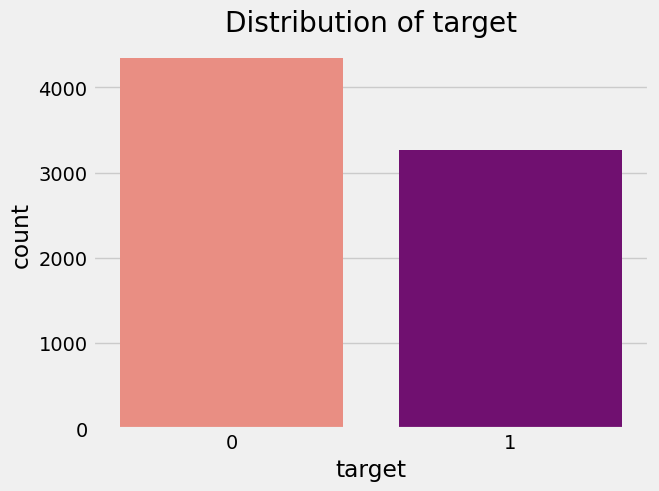

In [31]:
plt.style.use('fivethirtyeight')
sns.countplot(x = 'target', data = train_df, palette = ['salmon', 'purple'])
plt.title('Distribution of target')
plt.show()

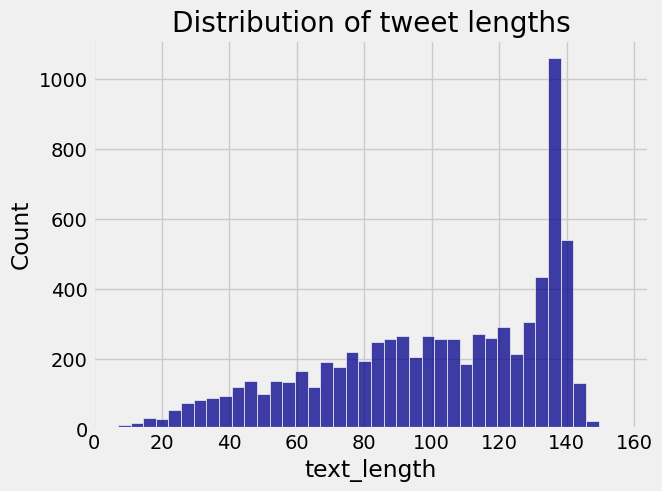

In [32]:
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(train_df['text_length'], bins = 40, color = 'darkblue')
plt.title('Distribution of tweet lengths')
plt.show()

## Data Preprocessing

In the data preprocessing stage, we will continue to prepare our dataset for the modeling phase later in this notebook. Before we can begin modeling, we will need to tokenize the dataset by using the Tokenize package from Tensorflow.

Tokenizing is an NLP pre-processing tool that takes a corpus of text as an input, breaks the document down into individua words, counts the individual words, and finally outputs numerical features that can be used in numerous machine learning models. The Vectorize class is very important, and allows for the model to carry out it's predictive power.

In [33]:
# first we define the Tokenizer. In this case, we will take the top 5,000 number
# of words. Then fit_on_texts will be called to fits the Tokenizer on to our
# cleaned_text column
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_df['cleaned_text'])

In [34]:
# texts_to_sequences takes the text from our cleaned_text column and converts it to a
# sequence of integers based on the fitted tokenizer
X_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

In [35]:
# the max length of the sequences will be padded to be at least 100 characters.
# If the sequences is less than 100 characters, then zeros will be added
max_len = 100
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
X_test = pad_sequences(X_test, padding = 'post', maxlen = max_len)

In [36]:
# grabbing the values from the target column
y_train = train_df['target'].values

In [37]:
# splitting the data into training and validation datasets and leaving
# out 15% of the data to test on.
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size = .15, random_state = 42)

## Model Building

For the first model, we will built a bi-directional LSTM model that will have the ability to classify the tweets as an actual disaster or non-disaster. The model will consist of an embedding layer, two bi-directional LSTM layers, and a dense output layer. The output layer will have a sigmoid activation function.

In [38]:
# creating the individual layers including a Input, Embedding, Bidirectional LSTM,
# Dropout and output layer all using the Tensorflow package
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim = 5000, output_dim = 128)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout_layer = Dropout(0.3)(bi_lstm_layer)
bi_lstm_layer_2 = Bidirectional(LSTM(64))(dropout_layer)
output_layer = Dense(1, activation = 'sigmoid')(bi_lstm_layer_2)

In [39]:
# compiling the model with the input and output layer from above. 
# Setting the learning rate to .00005 and setting the loss function to binary crossentropy
model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = Adam(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

## Model Training

With our model created, we can now fit the model to the train data that we split earlier in the notebook. The number of epochs will be set to 10 and the batch size to 16. The accuracy will be measured against the validation data.

These parameters were determined by balancing the time it takes for the model to train, and the increased epoch accuracy.

In [40]:
# fitting the model on our training data, and measuring its accuracy against the
# validation dataset. Also setting the number of epochs to 10 and the batch size to 16 
history = model.fit(X_train_split, y_train_split, epochs = 10, batch_size = 16, validation_data = (X_val_split, y_val_split))

Epoch 1/10


405/405 ━━━━━━━━━━━━━━━━━━━━ 70s 165ms/step - accuracy: 0.5706 - loss: 0.6872 - val_accuracy: 0.5701 - val_loss: 0.6746
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 73s 179ms/step - accuracy: 0.5812 - loss: 0.6693 - val_accuracy: 0.5701 - val_loss: 0.6632
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 72s 178ms/step - accuracy: 0.5865 - loss: 0.6556 - val_accuracy: 0.6270 - val_loss: 0.6463
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 72s 179ms/step - accuracy: 0.6274 - loss: 0.6402 - val_accuracy: 0.6454 - val_loss: 0.6319
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 75s 185ms/step - accuracy: 0.6402 - loss: 0.6282 - val_accuracy: 0.6515 - val_loss: 0.6246
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 75s 186ms/step - accuracy: 0.6517 - loss: 0.6162 - val_accuracy: 0.6629 - val_loss: 0.6151
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 75s 186ms/step - accuracy: 0.6795 - loss: 0.5971 - val_accuracy: 0.6900 - val_loss: 0.5974
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 76s 187ms/step - accuracy: 0.7232 - loss: 0.5619 - val

## Model Evaluation

After about 20 minutes of allowing our model to train. We received a max accuracy score of ~83%. However, if you remember, the Kaggle competition stated the accuracy metric is the F1 score. We can use the f1_score package from the sklearn library to easily calculate the score using our predictions.

The overall F1 validation score is ~.724 which is quite good for our initial model. The graph below showcases the validation accuracy and loss over the 10 epochs. Based on the model accuracy graph, it looks like both accuracy scores improved steadily throughout the epochs. The learning rate seemed to be correctly set at .00005. One change that could be made is to increase the number of epochs. Since the accuracy increased steadily throughout each epoch, it would be interesting to increase the number of epochs to see if the accuracy levels off or continues to increase. 

In [41]:
# predicting on our validation dataset and setting the predictions to binary.
# Then calculating the f1_score using our predictions and Y validation dataset.
val_predictions = model.predict(X_val_split)
val_predictions = (val_predictions > 0.5).astype(int)
val_f1 = f1_score(y_val_split, val_predictions)
print(f'Validation F1 score: {val_f1}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Validation F1 score: 0.74501573976915


### Training and Validation Accuracy and Loss

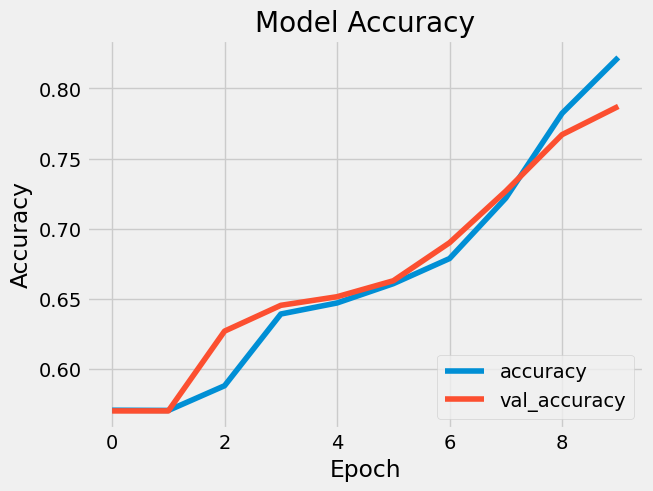

In [42]:
# graphing the accuracy and and loss throughout the epochs
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Model Accuracy')
plt.show()

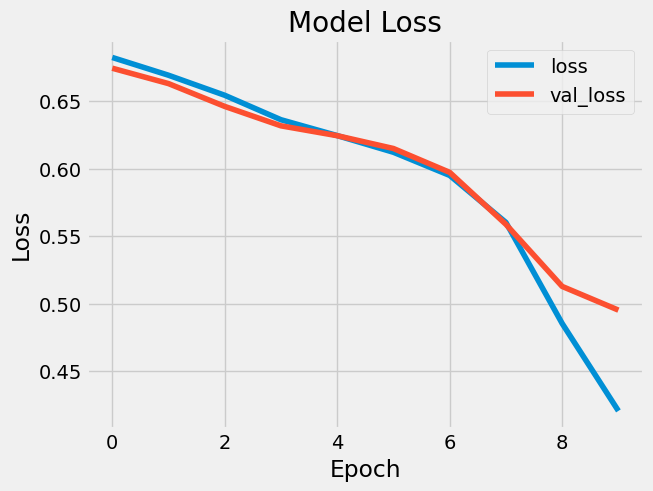

In [43]:
# graphing the model loss throughout the epochs
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Model Loss')
plt.show()

## Creating the Submission File

After trainining, fitting, and evaluating the model, we will now use it to make our final predictions on the testing dataset. Then, the predictions will be output to a csv for us to upload to Kaggle.

In [44]:
# creating the predictions and making them binary 
test_predictions = model.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int).flatten()

# creating a DataFrame 
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_predictions})
submission_df.to_csv('submission.csv', index = False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step


## Conclusion

In conclusion, throughout this notebook, there were multiple steps that needed to be completed to get a prediction on whether or not the tweet should be classified as an actual disaster or not. 

1. Data Loading and Preprocessing:
    - Loaded both the training and test datasets from Kaggle.
    - Preprocessing was completed by converting the Tweet text to lowercase, removinng non characters, and eliminated sklearn stop words.

2. EDA:
    - The distribution of the target was mostly balanced, with a few more non-disaster Tweets included in the dataset compared to disaster Tweets.
    - The distibution of tweets was centered around 120-140 characters, which helped in padding our model.

3. Model Building and Training: 
    - The Bi-directional LSTM model was created using an embdding layer, two bi-directional LSTM layers, and a dropout layer to prevent overfitting.
    - The model was compliled using an Adam optimizer and included binary cross-entropy as the loss function.
    - The model was trained for 10 epochs and included a batch size of 16.

4. Model Evaluation:
    - The model was evaluated based on the F1 score on the validation dataset, which topped out at a score of .72

In summary, this notebook demonstrated an entire end to end approach to classify text data using a Bi-directional LSTM model. The model performed quite well and with future enhancements, the model could achieve an even better overall accuracy.

### Performance and Potential Improvements

The Bi-directional LSTM model performed well in classifying the disaster tweets. This is clear from the increase in accuracy throughout our epochs. Even with our final max F1 score of .72, there were some areas that could be improved to achieve a higher score:

    - Hyperparameter tuning: Although some hyperparameter tuning was done in the initial model, even more tuning could be done to increase the models predictive power.
    - Additional models: Using other models like Transformer-based architectures could enchance the model's ability.
    - Data Augumentation: Data augumentation such as adding additional relevant Tweets could improve the models predictive ability.

### Future Work

Some future work that could be completed based on the initial approach presented in this notebook could include:
    - Implementing transformer-based models
    - Attempting text pre-processing techinques and data augumentation to allow for additional data to be included
    - Attempting cross validation to ensure the model parameters are optimized.